In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

# pathroot = 'C:\Users\ENZOA\OneDrive - Aix-Marseille Université\DESU\Groupe\G\en.openfoodfacts.org.products.csv'


In [44]:
data = pd.read_csv(r'C:\Users\ENZOA\OneDrive - Aix-Marseille Université\DESU\Groupe\G\en.openfoodfacts.org.products.csv', nrows=100000, sep='\t', encoding='utf-8')
data = data[data['nutriscore_grade'].notna()]

C:\Users\ENZOA\AppData\Local\Temp\ipykernel_19380\3245471066.py:1: DtypeWarning: Columns (11,34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r'C:\Users\ENZOA\OneDrive - Aix-Marseille Université\DESU\Groupe\G\en.openfoodfacts.org.products.csv', nrows=100000, sep='\t', encoding='utf-8')


In [45]:
len(data)

99495

In [46]:
df=data.copy()

In [47]:
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")
df = df.drop_duplicates(keep='first')
len(df)

Number of duplicate rows: 0


99495

In [66]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False,inplace=True)
threshold_view = 20

filtered = percent_missing[percent_missing.values < threshold_view]

print(f"Columns with less than {threshold_view}% missing values:")
print(filtered)
print(len(filtered))

datafiltered= df[filtered.index]



datafv2 = datafiltered.copy()
datafv2bis = datafv2.drop(columns=['code', 'url', 'creator', 'created_t', 'last_modified_t', 'last_modified_by', 'created_datetime','states','last_updated_t',
                                'states_tags','countries','countries_tags','countries_en','last_modified_datetime','states_en','product_name','last_updated_datetime'])


from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OrdinalEncoder

# Encodage des données catégoriques
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(datafv2bis)

# Application de VarianceThreshold
selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(encoded_data)

print("Features sélectionnées après VarianceThreshold :")
print(selected_features)

datafv3bis = pd.DataFrame(selected_features, columns=datafv2bis.columns[selector.get_support()])

datafv3 = datafv3bis.copy()
datafv3['product_name'] = datafv2['product_name']


Columns with less than 20% missing values:
fat_100g                  19.583899
proteins_100g             19.524599
carbohydrates_100g        19.236143
energy-kcal_100g          19.048193
energy_100g               18.808985
last_modified_by          12.831801
product_name               4.480627
countries_tags             0.541736
countries_en               0.541736
countries                  0.540731
last_updated_datetime      0.000000
nutriscore_grade           0.000000
pnns_groups_1              0.000000
creator                    0.000000
created_t                  0.000000
created_datetime           0.000000
pnns_groups_2              0.000000
last_modified_t            0.000000
last_modified_datetime     0.000000
states                     0.000000
last_updated_t             0.000000
states_tags                0.000000
states_en                  0.000000
completeness               0.000000
url                        0.000000
code                       0.000000
dtype: float64
26
Fea

In [68]:
print(datafv3bis.isnull().sum())

fat_100g              19485
proteins_100g         19426
carbohydrates_100g    19139
energy-kcal_100g      18952
energy_100g           18714
nutriscore_grade          0
pnns_groups_1             0
pnns_groups_2             0
completeness              0
dtype: int64


In [74]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3, weights='uniform')
imputed_data = imputer.fit_transform(datafv3bis)



In [75]:
imputed_df = pd.DataFrame(imputed_data, columns=datafv3bis.columns)

Outliers : 4975 on 99495 total samples
Pourcentage d'outliers : 5.00%


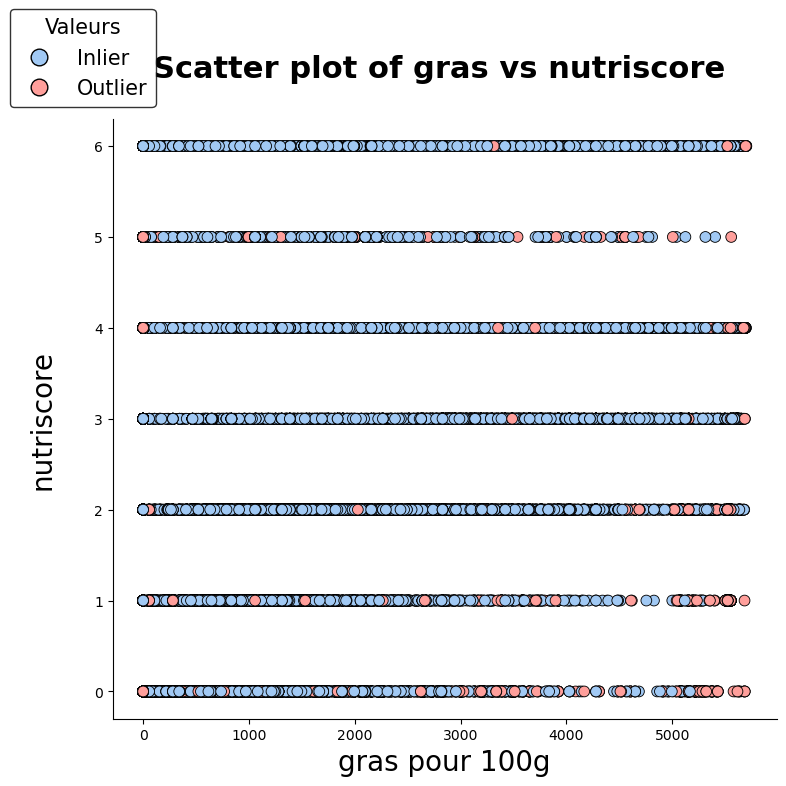

In [79]:
from sklearn.ensemble import IsolationForest
from matplotlib.lines import Line2D

model = IsolationForest(contamination=0.05, random_state=42)
preds = model.fit_predict(imputed_df)
outlier_indices = np.where(preds == -1)[0]
print(f"Outliers : {len(outlier_indices)} on {len(imputed_df)} total samples")
print (f'Pourcentage d\'outliers : {len(outlier_indices) / len(imputed_df) * 100:.2f}%')
cmap = sns.color_palette("pastel")

plt.figure(figsize=(8, 8))
palette = {1: cmap[0], -1: cmap[3]}
pax = sns.scatterplot(
    x=imputed_df['fat_100g'],
    y=imputed_df['nutriscore_grade'],
    hue=preds,
    palette=palette,
    edgecolor='k',
    s=60,
    legend=False
)
plt.xlabel('gras pour 100g', fontsize=20)
plt.ylabel('nutriscore\n', fontsize=20)
plt.title("Scatter plot of gras vs nutriscore \n", fontsize=22, fontweight='bold')
axes = plt.gca()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Inlier', markerfacecolor=cmap[0], markersize=12, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='Outlier', markerfacecolor=cmap[3], markersize=12, markeredgecolor='k')
]
plt.legend(handles=legend_elements, title="Valeurs", fontsize=15, title_fontsize=15, frameon=True, loc='upper right', bbox_to_anchor=(0.08, 1.2), framealpha=0.8, edgecolor='black')
plt.tight_layout()
plt.savefig('freetime_vs_G3_outliers.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [89]:
from sklearn.model_selection import train_test_split


imputed_df2 = imputed_df.drop(columns=['nutriscore_grade'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(imputed_df2, imputed_df['nutriscore_grade'], test_size=0.20, random_state=42)


In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
XTT = scaler.fit_transform(X_train)

In [95]:
import statsmodels.api as sm
import numpy as np

model = sm.OLS(y_train,XTT)
results = model.fit()
results.params

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:        nutriscore_grade   R-squared (uncentered):                   0.306
Model:                             OLS   Adj. R-squared (uncentered):              0.306
Method:                  Least Squares   F-statistic:                              4381.
Date:              ven., 11 juil. 2025   Prob (F-statistic):                        0.00
Time:                         12:09:06   Log-Likelihood:                     -2.2237e+05
No. Observations:                79596   AIC:                                  4.448e+05
Df Residuals:                    79588   BIC:                                  4.448e+05
Df Model:                            8                                                  
Covariance Type:             nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.1553      0.041     76.055      0.000       3.074       3.237
x2             1.3382      0.029     46.152      0.000       1.281       1.395
x3             3.4234      0.037     92.795      0.000       3.351       3.496
x4            -8.2699      0.101    -81.657      0.000      -8.468      -8.071
x5             5.0466      0.099     51.006      0.000       4.853       5.240
x6            -0.2636      0.007    -37.159      0.000      -0.278      -0.250
x7            -0.3252      0.008    -39.350      0.000      -0.341      -0.309
x8            -1.9069      0.019    -99.181      0.000      -1.945      -1.869
==============================================================================
Omnibus:                     1456.674   Durbin-Watson:                   1.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1537.431
Skew:                          -0.339   Prob(JB):                         0.00
Kurtosis:                       3.058   Cond. No.                         40.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

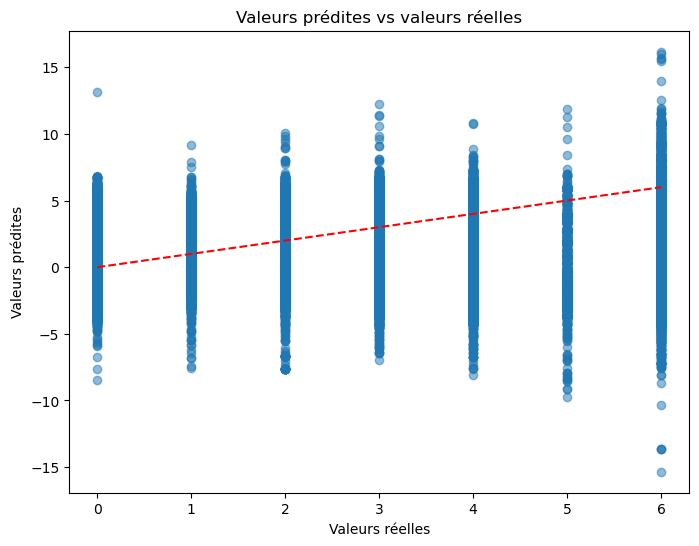

In [98]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train, results.predict(XTT), alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs valeurs réelles')
plt.show()

In [ ]:
df_clean = final_df2[~final_df2.index.isin(outlier_indices)]
print(f"Nombre d'outliers = {len(outlier_indices)}")
print(f"DataFrame propre des outliers: {df_clean.shape[0]} lignes restantes sur {final_df2.shape[0]} lignes initiales")
df_clean

Gardons les outliers

In [ ]:
#enlevons des colonnes qui ne sont pas pertinentes
df_clean_cut = df_clean.drop(columns=['code', 'created_t', 'last_modified_t', 'last_modified_t', 'last_update_t', 'serving_quantity'], errors='ignore')
print(df_clean.shape)
print(df_clean_cut.shape)                         

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression
X = df_clean_cut.columns[df_clean_cut.columns != 'nutriscore_grade']
y = df_clean_cut['nutriscore_grade']

# Sélection des k meilleures variables explicatives (par exemple k=50)
k = 20
selector = SelectKBest(score_func=chi2, k=k)
X_kbest = selector.fit_transform(X, y)

# Pour obtenir les noms des colonnes sélectionnées (si X est un DataFrame)
selected_columns = X.columns[selector.get_support()]
print("Colonnes sélectionnées :", list(selected_columns))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import os
from IPython.display import display, HTML
from matplotlib.lines import Line2D
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import shap

from sklearn.preprocessing import LabelEncoder

In [ ]:
#faisons un kbest
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
final_df2_sans_na_array = imputer.fit_transform(df_clean)
final_df2_sans_na = pd.DataFrame(final_df2_sans_na_array, columns=df_clean.columns)
final_df2_sans_na

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# 1. Imputation sur données brutes
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(final_df2)

# 2. Scaling (RobustScaler ou autre)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 3. PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

#plot
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, s=10)
plt.title('PCA of Nutritional Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
bins = [-1, 5, 10, 15, 20]
labels = [0, 1, 2, 3]

feature_names = final_df2_sans_na.columns[final_df2_sans_na.columns != 'nutriscore_score']

y_grouped = pd.cut(final_df2_sans_na['nutriscore_score'], bins=bins, labels=labels)

# Supprime les lignes où y_grouped est NaN
mask = ~y_grouped.isna()
y_grouped = y_grouped[mask].astype(int)

# Sélection lignes avec mask
X_filtered = df_robust_avec_out[mask.values, :]  # toutes les colonnes

# Sélection colonnes dans un second temps
col_indices = final_df2_sans_na.columns.get_indexer(feature_names)
X_selected = X_filtered[:, col_indices]

# Création DataFrame
X_df = pd.DataFrame(X_selected, columns=feature_names)

# Labels
y = y_grouped[mask].astype(int).values


feature_names = final_df2_sans_na.columns[final_df2_sans_na.columns != 'nutriscore_score']
X_df = pd.DataFrame(df_robust_avec_out[:, final_df2_sans_na.columns.get_indexer(feature_names)], columns=feature_names)
y = y_grouped.values


X_train, X_test, y_train, y_test = train_test_split(X_df, y, train_size=0.8, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(feature_names))
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(feature_names))

params = {
    'objective': 'multi:softmax',
    'eval_metric': 'merror',
    'num_class': 4,
    'max_depth': 5,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'gamma': 0,
    'alpha': 0.1,
    'lambda': 1
}

cv_results = xgb.cv(
    params, 
    dtrain, 
    num_boost_round=200, 
    nfold=5, 
    metrics='merror',
    early_stopping_rounds=20,
    verbose_eval=False
)

best_rounds = cv_results['test-merror-mean'].argmin() + 1
print(f"Best number of rounds: {best_rounds}")

model = xgb.train(params, dtrain, num_boost_round=best_rounds)

predictions = model.predict(dtest)
accuracy = accuracy_score(y_test, predictions)
print(f'XGBoost Accuracy: {accuracy:.4f}')

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0–5', '6–10', '11–15', '16–20'],
            yticklabels=['0–5', '6–10', '11–15', '16–20'])
plt.xlabel('Note Prédite')
plt.ylabel('Note Réelle')
plt.title('Matrice de confusion - XGBoost')
plt.tight_layout()
plt.savefig('confusion_matrix_xgboost.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

importances = model.get_score(importance_type='gain')
df_importance = pd.DataFrame(importances.items(), columns=['feature', 'importance'])
df_importance = df_importance.sort_values(by='importance', ascending=False)

df_bis = df_importance[2:]
palette = sns.color_palette("pastel", len(df_importance)) 
feature_colors = dict(zip(df_importance['feature'], palette))

plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_importance,
    y='feature',
    x='importance',
    hue='feature',
    palette=feature_colors,
    dodge=False,
    legend=False
)

plt.title('Importance des variables sur les résultats en maths\n', fontsize=22, fontweight='bold')
plt.xlabel('\nGain moyen', fontsize=20) 
plt.ylabel('Features\n', fontsize=20)
plt.grid(False)
axes = plt.gca()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('feature_importance_xgboost.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

print(f"XGBoost Accuracy: {accuracy:.4f}")




In [ ]:
print(df_robust_avec_out.shape)
print(final_df2.shape)
print(len(mask))
print(mask.sum())
